In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [103]:
!pip install razdel
!pip install python-Levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 4.4 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149860 sha256=b7116a3b2988faa0876ab5423cdfc154652f27598d63a288f8df0de36800188f
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein


In [104]:
import cv2
import numpy as np
import sys
import re
from razdel import tokenize

from torchvision.models import googlenet
import torch
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Normalize, Resize, ToTensor, RandomErasing, RandomAffine
from PIL import Image
from Levenshtein import distance as levenshtein_distance


from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import os
import random
from pathlib import Path
from glob import glob
from tqdm.notebook import tqdm
from string import punctuation, whitespace

# Инференс

## Инференс модели torch. Инфраструктура

### Полезности (запусти меня)

Данные для инференса

In [9]:
from skimage import img_as_bool
from skimage.color import rgb2gray
from skimage.morphology import skeletonize, binary_closing, thin
import skimage

In [10]:
# !cp /content/drive/MyDrive/Disser/dictation_text.txt .
# !cp /content/drive/MyDrive/Disser/dataset_more_data.zip .
# !cp /content/drive/MyDrive/Disser/words.zip .
# !unzip -qq -o dataset_more_data.zip
# !unzip -qq -o words.zip
!ls dataset_more_data
!ls dataset_more_data | wc -l

dash	q_mark	б  г  е  ж  и  к  м  о	р  т  ф  ц  ш  ъ  ь  ю
e_mark	а	в  д  ё  з  й  л  н  п	с  у  х  ч  щ  ы  э  я
36


In [11]:
!cp /content/drive/MyDrive/Disser/dataset_cropped_chars.zip .
!unzip -qq -o dataset_cropped_chars.zip
!ls dataset_cropped_chars
!ls dataset_cropped_chars | wc -l

dash	а  Б  г  е  Ж  И  К  м	Н  п  Р  т  У  Х  ш  ы	ю
e_mark	А  в  д  ё  з  й  л  М	о  П  с  Т  ф  ц  щ  ь	я
q_mark	б  В  Д  ж  и  к  Л  н	О  р  С  у  х  ч  ъ  э	Я
54


In [12]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

препроцессинг

In [64]:
def add_margin(pil_img, top=0, right=0, bottom=0, left=0, color=(255,255,255)):
    """
    add margin to an image. Any side you want!
    """
    width, height = pil_img.size
    new_width = width + right + left
    new_height = height + top + bottom
    result = Image.new(pil_img.mode, (new_width, new_height), color)
    result.paste(pil_img, (left, top))
    return result

def binarize(pic):
    """
    get a representation of this picture as an numpy matrix
    numbers are floating-point non-integers (8-bit pixels, black and white)
    """
    wd, ht = pic.size
    pixels = np.array(pic.convert('L').getdata(), np.uint8)
    bin_img = 1 - (pixels.reshape((ht, wd)) / 255.0)
    return bin_img

def put_in_a_box(char: 'Image'):
    """
    cut an image with white background, making it a "box" that borders the first encountered non-white
    parts of the image, e.g. bordering each side of a letter
    """
    bin_img = binarize(char)
    height, width = bin_img.shape
    def find_border(bin_img):
        for (idx, row) in enumerate(bin_img):
            if np.sum(row) > 0:
                return idx
    
    left = find_border(bin_img.T)
    top = find_border(bin_img)
    if left is None or top is None:
      return None
    right = width - find_border(bin_img.T[::-1, :])
    bottom = height - find_border(bin_img[::-1, :])
    
    return char.crop((left, top, right, bottom))

def pil2cv(pil_img):
  return np.array(pil_img)[:, :, ::-1]

def cv2pil(cv2_img):
  return Image.fromarray(cv2_img)

def delete_bad_contour(image: Image, min_area=30):
  # Load image, convert to grayscale, Gaussian blur, Otsu's threshold
  image = pil2cv(image)
  blur = cv2.GaussianBlur(image, (3,3), 2)
  gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
  thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

  # Filter using contour area and remove small noise
  cnts = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  cnts = cnts[0] if len(cnts) == 2 else cnts[1]
  for c in cnts:
      area = cv2.contourArea(c)
      if area < min_area:
          cv2.drawContours(thresh, [c], -1, (0,0,0), -1)
  color_converted = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
  res = cv2.bitwise_and(image-255, color_converted)
  color_converted = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
  pil_image=cv2pil(color_converted+255)
  return pil_image

def preprocess(image: Image, 
               min_contour, 
               padding=5,
               deacrease_contour_if_none=False):
  while True:
    only_large_countour = delete_bad_contour(image, min_contour)
    boxed = put_in_a_box(only_large_countour)
    if boxed is None and deacrease_contour_if_none:
      min_contour -= 1
    else: break
  return add_margin(boxed, padding,padding,padding,padding)

для сохранения файлов в одном месте без конфликта наименований

In [65]:
def next_path(path_pattern):
    """
    Finds the next free path in an sequentially named list of files
    e.g. path_pattern = 'file-%s.txt':
    """
    i = 1

    while os.path.exists(path_pattern % i):
        i = i * 2

    a, b = (i // 2, i)
    while a + 1 < b:
        c = (a + b) // 2 # interval midpoint
        a, b = (c, b) if os.path.exists(path_pattern % c) else (a, c)

    return path_pattern % b

Для загрузки модели

In [16]:
def load_custom_model_from_pt(fp, model, device, eval=True):
    model.load_state_dict(torch.load(fp, map_location=torch.device(device)))
    if eval:
        model.eval()
    return model

def load_resnet18_model_from_pt(fp, num_of_classes, device, eval=True):
    model = resnet18(pretrained=True)
    model.fc = torch.nn.Linear(512, num_of_classes)
    model.load_state_dict(torch.load(fp, map_location=torch.device(device)))
    if eval:
        model.eval()
    return model

def load_googlenet_model_from_pt(fp, num_of_classes, device, eval=True):
    model = googlenet(pretrained=True)
    model.fc = torch.nn.Linear(1024, num_of_classes)
    model.load_state_dict(torch.load(fp, map_location=torch.device(device)))
    if eval:
        model.eval()
    return model

Для предсказания по модели torch

In [17]:
def predict_image(model_instance, class_names, image, transform, device="cpu"):
    image_tensor = transform(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = torch.autograd.Variable(image_tensor)
    input = input.to(device)
    output = model_instance(input)
    index = output.data.cpu().numpy().argmax()
    return class_names[index]

#### Цепь маркова

In [18]:
class MarkovChain:
    START_TOKEN = " "
    
    def __init__(self, text: str, sequence_size:int):
        """
        Markov chain allows us to predict the next element of a sequence based
         on the current state. Here we predict the next character based of a
         given sequence of characters.
        
        parameters:
            text:          one string that contains the whole text on which the chain
                            is going to be based
            sequence_size: to predict the next element we take into account the last N
                            elements of a given sequence. This parameter is the N.
        """
        self.seq_size = sequence_size
        self.text = text
        self.corpus = self.normalize()
        self.all_chars = sorted(list(set(''.join(self.corpus)) - set(whitespace)))
        self.char_to_id = self.__char_to_id__()
        self.id_to_char = {v: k for k, v in self.char_to_id.items()}
        self.M = self.__coocurrance_matrix__()
        
    def predict_next_char(self, chars) -> str:
        assert len(chars) == self.seq_size
        
        id_tupl = tuple([self.char_to_id[char] for char in chars])
        next_id: int = np.argmax(self.M[id_tupl])
        if next_id == 0:
            # Every char has equal probability, most possibly 0, and <END> tag is returned
            return None 
        next_char: str = self.id_to_char[next_id]
        return next_char
        
    def proba(self, prev, next_) -> float:
        
        try:
          assert len(prev) == self.seq_size
          assert next_ in self.char_to_id
          id_tupl = tuple([self.char_to_id[char] for char in prev])
          next_id = self.char_to_id[next_]
          proba = self.M[id_tupl][next_id]
        except:
          proba = 0
        return proba
    
    def normalize(self):
        tokens = [t.text.strip(punctuation) for t in tokenize(self.text)]
        return [t for t in tokens if len(t) > 0]
    
    def __coocurrance_matrix__(self):
        M = np.zeros(tuple(
                    [len(self.char_to_id)] * (self.seq_size+1)
                 ))
        for word in self.corpus:
            # srez has size `self.seq_size` + 1
            for srez in self.__char_groups__(word):
                ids = tuple([self.char_to_id[char] for char in srez])
                M[ids] += 1
        return M
                
        
    def __char_to_id__(self):
        char_to_id = {
            MarkovChain.START_TOKEN: 0,
        }
        for i, char in enumerate(self.all_chars):
            i += 1
            char_to_id[char] = i
        return char_to_id
        
    def __char_groups__(self, word):
        word: list = list(word)
        size = self.seq_size

        # padding
        for i in range(size):
            word.insert(0, MarkovChain.START_TOKEN)
        
        for i in range(len(word)-size):
            yield tuple(word[i:i+size+1])

In [19]:
class MarkovChainLight:
    START_TOKEN = " "
    
    def __init__(self, text: str, sequence_size:int):
        """
        Markov chain allows us to predict the next element of a sequence based
         on the current state. Here we predict the next character based of a
         given sequence of characters.
        
        parameters:
            text:          one string that contains the whole text on which the chain
                            is going to be based
            sequence_size: to predict the next element we take into account the last N
                            elements of a given sequence. This parameter is the N.
        """
        self.seq_size = sequence_size
        self.text = text
        self.corpus = [text]
        self.all_chars = sorted(list(set(''.join(self.corpus)) - set(whitespace)))
        self.char_to_id = self.__char_to_id__()
        self.id_to_char = {v: k for k, v in self.char_to_id.items()}
        self.M = self.__coocurrance_matrix__()
        
    def predict_next_char(self, chars) -> str:
        assert len(chars) == self.seq_size
        
        id_tupl = tuple([self.char_to_id[char] for char in chars])
        next_id: int = np.argmax(self.M[id_tupl])
        if next_id == 0:
            # Every char has equal probability, most possibly 0, and <END> tag is returned
            return None 
        next_char: str = self.id_to_char[next_id]
        return next_char
        
    def proba(self, prev, next_) -> float:
        
        try:
          assert len(prev) == self.seq_size
          assert next_ in self.char_to_id
          id_tupl = tuple([self.char_to_id[char] for char in prev])
          next_id = self.char_to_id[next_]
          proba = self.M[id_tupl][next_id]
        except:
          proba = 0
        return proba
    
    def normalize(self):
        tokens = [t.text.strip(punctuation) for t in tokenize(self.text)]
        return [t for t in tokens if len(t) > 0]
    
    def __coocurrance_matrix__(self):
        M = np.zeros(tuple(
                    [len(self.char_to_id)] * (self.seq_size+1)
                 ))
        for word in self.corpus:
            # srez has size `self.seq_size` + 1
            for srez in self.__char_groups__(word):
                ids = tuple([self.char_to_id[char] for char in srez])
                M[ids] += 1
        return M
                
        
    def __char_to_id__(self):
        char_to_id = {
            MarkovChainLight.START_TOKEN: 0,
        }
        for i, char in enumerate(self.all_chars):
            i += 2
            char_to_id[char] = i
        return char_to_id
        
    def __char_groups__(self, word):
        word: list = list(word)
        size = self.seq_size

        # padding
        for i in range(size):
            word.insert(0, MarkovChainLight.START_TOKEN)
        
        for i in range(len(word)-size):
            yield tuple(word[i:i+size+1])

## Предсказание

### Лучшая модель, её датасет

In [28]:
model_path = "/content/drive/MyDrive/models/cnn_podelka_65ep.pt"
double_conv_model_with_scheduling = torch.nn.Sequential(
  torch.nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5),
  torch.nn.ReLU(),
  torch.nn.MaxPool2d(kernel_size=2),
  torch.nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5),
  torch.nn.ReLU(),
  torch.nn.MaxPool2d(kernel_size=2),
  torch.nn.Flatten(),
  torch.nn.Linear(1620, 512),
  torch.nn.ReLU(),
  torch.nn.Linear(512, 36),
  )
best_model = load_custom_model_from_pt(model_path, double_conv_model_with_scheduling, device)

# model_path = "/content/drive/MyDrive/models/cnn_podelka_cropped_chars.pt"
# double_conv_model_with_scheduling = torch.nn.Sequential(
#   torch.nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5),
#   torch.nn.ReLU(),
#   torch.nn.MaxPool2d(kernel_size=2),
#   torch.nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5),
#   torch.nn.ReLU(),
#   torch.nn.MaxPool2d(kernel_size=2),
#   torch.nn.Flatten(),
#   torch.nn.Linear(1620, 512),
#   torch.nn.ReLU(),
#   torch.nn.Linear(512, 54),
#   )
# best_model = load_custom_model_from_pt(model_path, double_conv_model_with_scheduling, device)

In [26]:
transform = Compose(
        [
            Resize((50, 50)), 
            # RandomAffine(degrees=15),
            ToTensor(),
            # RandomErasing(inplace=True),
            Normalize(mean=[0.485, 0.456, 0.406],
                      std=[0.229, 0.224, 0.225])
        ]
    )
dataset = ImageFolder(
    "./dataset_more_data", 
    transform=transform
)
class_names = list(dataset.class_to_idx.keys())
classes = {v: k for k,v in dataset.class_to_idx.items()}
print(class_names)

# transform = Compose(
#         [
#             Resize((50, 50)), 
#             # RandomAffine(degrees=15),
#             ToTensor(), 
#             # RandomErasing(inplace=True),
#             # Normalize(mean=[0.485, 0.456, 0.406],
#             #           std=[0.229, 0.224, 0.225]),
#             RandomErasing(value=(-255,-255,-255), ratio=(.3, .4), scale=(.1, .1)),
#         ]
#     )
# dataset = ImageFolder(
#     "./dataset_cropped_chars", 
#     transform=transform
# )

# class_names = list(dataset.class_to_idx.keys())
# classes = {v: k for k,v in dataset.class_to_idx.items()}
# print(class_names)

['dash', 'e_mark', 'q_mark', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё']


### Непосредственно предсказание

#### Скользящее окно. Поскользнулось и не работает

In [30]:
def parse_word_with_incremental_window(
    path,
    classifier,
    chain,
    dataset,
    device,
    window_min_size=15,
    window_max_size=50,
    window_growth_step=5,
    window_slide_step=5,
    markov_threshold: float = 0.,
    save_img: bool = False,
    save_path: bool = None):
  """
  Sliding window goes through the image located at `path`. It is defined by its 
    leftmost position and its size, i.e. how far right it spans. 
  With each attempt at recognition of a letter the window will grow from `window_min_size` to `window_max_size` with step `window_growth_step`
    until it either successfully predicts a letter or can grow no more.
  Either the probability of prediction must be >= `classification_threshold`,
      or the probability of this letter being a continuation of the previous sequence must be >= `markov_threshold`.

  Parameters:
    path: path to an image of a word
    classifier: sklearn classifier or anything that has same interface for prediction
    chain: Markov chain to evaluate, how well the predicted char fits in the previous sequence.
    dataset: pytorch dataset. Is used to take classes and transform object from it
    device: cuda or cpu
    window_min_size: the starting width of a sliding window
    window_max_size: the max width of a sliding window.
    window_growth_step: how much a sliding window grows if no char was recognised for current size. 
                        Window never grows beyond `window_max_size` or the width of the image.
    window_slide_step: the step of a sliding window, like a stride in a CNN
    classification_threshold: how high must the probability of prediction be qualify for a valid classification
    markov_threshold: how high must the probability of a letter-sequence be to qualify for a valid sequence
    save_img: whether the content of the window is saved, given that the prediction probability surpasses the thresholds
  """
  assert window_min_size <= window_max_size
  transform = dataset.transform
  classes = {v: k for k,v in dataset.class_to_idx.items()}
  word_img = Image.open(path)
  width,height= word_img.size

  if width < window_min_size:
    # if the image is very small, we will inspect it once and hope for the best
    window_min_size = width

  # left border of a window 
  position = 0
  # initial padding for markov chain
  inferred = [MarkovChain.START_TOKEN] * chain.seq_size
  pics = []
  while position <= width - window_min_size:
    window_size = window_min_size
    success = False

    while window_size <= window_max_size and position + window_size <= width:
      # print(f"Infering {path}. Position: {position}, window size: {window_size}")
      l, r = position, position + window_size 
      window = word_img.crop((l,0,r,height))
      pad_size = 5 ## (BASE_WIDTH-window.width)//2
      resized = preprocess(
          window,
          padding=10,
          min_contour=30,
          deacrease_contour_if_none=True,
      )      
      letter = predict_image(classifier, classes, resized, transform, "cpu")
      markov_sure = chain.proba(inferred[-chain.seq_size:], next_=letter) >= markov_threshold
      if markov_sure:
        # print(f"COOL! Infered {letter}. Position: {position}, window size: {window_size}. Markov: {markov_sure}, Predictor: {predictor_sure}")
        success = True
        inferred.append(letter)
        pics.append(resized)
        if save_img and save_path is not None:
          path_prefix = f"{save_path}/{letter}"
          os.makedirs(path_prefix, exist_ok=True)
          target_loc = next_path(path_pattern=f"{path_prefix}/{letter}-%s.jpg")
          window.save(target_loc)
        break
      else:
        window_size += window_growth_step
    if success is True:
      # this window contained a letter, so we can go further for its whole width
      position += window_size
    else:
      position += window_slide_step
  return pics, inferred[chain.seq_size:]#''.join(inferred[chain.seq_size:])

['./words/57347_16/57347_16-0/12/2.jpg', './words/57347_16/57347_16-0/12/5.jpg', './words/57347_16/57347_16-0/12/0.jpg', './words/57347_16/57347_16-0/12/3.jpg', './words/57347_16/57347_16-0/12/4.jpg', './words/57347_16/57347_16-0/12/1.jpg', './words/57347_16/57347_16-0/12/6.jpg', './words/57347_16/57347_16-0/21/2.jpg', './words/57347_16/57347_16-0/21/0.jpg', './words/57347_16/57347_16-0/21/3.jpg', './words/57347_16/57347_16-0/21/4.jpg', './words/57347_16/57347_16-0/21/1.jpg', './words/57347_16/57347_16-0/19/2.jpg', './words/57347_16/57347_16-0/19/0.jpg', './words/57347_16/57347_16-0/19/3.jpg', './words/57347_16/57347_16-0/19/4.jpg', './words/57347_16/57347_16-0/19/1.jpg', './words/57347_16/57347_16-0/1/2.jpg', './words/57347_16/57347_16-0/1/5.jpg', './words/57347_16/57347_16-0/1/0.jpg', './words/57347_16/57347_16-0/1/3.jpg', './words/57347_16/57347_16-0/1/4.jpg', './words/57347_16/57347_16-0/1/1.jpg', './words/57347_16/57347_16-0/1/6.jpg', './words/57347_16/57347_16-0/1/7.jpg', './word

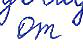

In [32]:
text = open("dictation_text.txt").read().lower()
chain = MarkovChain(sequence_size=3,text=text)
# 57347_16 хороший почерк
words = glob("./words/57347_16/**/*.jpg", recursive=True)
print(words)
word = words[26]
word_img = Image.open(word)
word_img

In [33]:
parsed = parse_word_with_incremental_window(
  path=word,
  classifier=best_model,
  chain=chain,
  dataset=dataset,
  device=device,
  markov_threshold=0.05,
  window_min_size=10
)
parsed

TypeError: ignored

#### Ещё что-то

1) "Большое" слово не может состоять из букв. Можно посчитать среднюю длину символа L пикселей: и рассчитывать, что слово, состоящее из `N*L +- e` состоит из N символов с погрешностью в пикселях e.

2) Граница буквы в любом случае пролегает там, где в колонке содержится 1 пиксель

3) Каждое новое слово - продолжение предыдущего: либо его часть, либо следует за ним в диктанте. Можно натравить марковскую цепь на это, т.е. предыдущие три символа - это не теги начала слова, а две буквы предыдущего слова и пробел.

In [ ]:


# def predict_word(
#     word: Image,
#     chain: MarkovChainLight,
#     window_min_size: int,
#     window_max_size: int,
#     window_slide_step: int,
#     window_growth_step: int):
#   PAD = 5
#   MIN_CONTOUR = 40
#   predicted = [chain.__class__.START_TOKEN] * chain.seq_size
#   images = []
#   window_max_size = min(word.width, window_max_size)
#   window = [0, 0, min(window_min_size,window_max_size), word.height]
#   # цикл для прохода по слову
#   while window[2] <= word.width:
#     # проверка на то, что правая граница окна не проходит через "закрытую" букву типа о,а,б,в. 
#     print(f"Validating window {window}.", end=" ")
#     while window[2] - window[0] < window_max_size and window[2] < word.width:
#       image = word.crop(window)
#       preprocessed = preprocess(
#         image,
#         padding=PAD,
#         min_contour=MIN_CONTOUR,
#         deacrease_contour_if_none=True,
#       )
#       plt.imshow(word)
#       if window_is_valid(preprocessed, PAD):
#         print(f" Valid! ")
#         break
#       else:
#         window[2] += 1
#         print(f" -> {window}", end=" ")
#     # цикл для изменения скользящего окна
#     while window[2] - window[0] <= window_max_size and window[2] <= word.width:
#       #trying to predict
#       # classes, best_model и transform берутся из среды!
#       letter = predict_image(best_model, classes, preprocessed, transform, "cpu")

#       if chain.proba(predicted[-chain.seq_size:], letter) > 0:
#         print(f"Predicted {letter} in {window}.", end=" ")
#         predicted.append(letter)
#         images.append(image)
#         window[0] = window[2]
#         window[2] += window_min_size
#         print(f"Window is now {window}")
#         break
#       else:
#         window[2] += window_growth_step
#         print(f"Prediction '{letter}' given context '{predicted[-chain.seq_size:]}' did not satisfy the chain. Window increased to {window}")
#     # только если окно разрослось, но так и не получилось ничего распознать
#     else:
#       window[0] += window_slide_step
#       window[2] = window[0] + window_min_size
#   return images, predicted[chain.seq_size:]

In [164]:
def calc_average_symbol_width(words: "List[Image]") -> float:
  return sum(map(lambda image: image.width, words)) / total_characters

def open_images(paths):
  words = []
  for each in paths:
    words.append(Image.open(each))
  return words

def window_is_valid(pil_image, pad):
  im = img_as_bool(binarize(pil_image))
  im = thin(binary_closing(skeletonize(im)))
  if pad:
    im = im[pad:-pad, pad:-pad]
  return im[:, -1].sum() < 2

def create_valid_window(window: "list[int]",
                        word_img: Image,
                        window_max_size: int,
                        PAD: int,
                        MIN_CONTOUR: int):
  """ ИЗМЕНЯЕТ ИЗНАЧАЛЬНЫЙ МАССИВ В КАЧЕСТВЕ САЙД ЭФФЕКТА """
  # расширяем окно, чтобы правая граница не проходила через "закрытую" букву типа о,а,б,в. 
  # в случае с такими буквами это позволяет провести правую границу окна через соединение с соседней буквой
  while window[2] - window[0] <= window_max_size and window[2] <= word_img.width:
    image = word_img.crop(window)
    preprocessed = preprocess(
      image,
      padding=PAD,
      min_contour=MIN_CONTOUR,
      deacrease_contour_if_none=True,
    )
    if window_is_valid(preprocessed, PAD):
      break
    else:
      window[2] += 1
  try:
    return image, preprocessed
  except Exception as e:
    # plt.imshow(word_img)
    # print("window, window_max_size, word_width")
    # print(window, window_max_size, word_img.width)
    # raise e
    pass
  

def predict_word_with_fallback(
    word: Image,
    chain: MarkovChainLight,
    average_char_width: int,
    window_min_size: int,
    window_max_size: int,
    window_slide_step: int,
    window_growth_step: int):
  PAD = 5
  MIN_CONTOUR = 40
  MAX_CONSECUTIVE_WINDOW_SLIDES = 3

  LEVENSTEIN_TOLERANCE = 1
  best_images = []
  best_letters = []

  # рекурсия для продвижения окна по слову с возможностью возвратиться в предыдущее состояние (вернувишь в контекст предыдущего вызова)
  def parse_word_rec(
      word_img: Image,
      accum_letters: "list[str]",
      accum_images = [],
      slides = 0
      ):
    accum_letters_as_str = ''.join(accum_letters[chain.seq_size:])
    # print(f"Parsing image of shape {word_img.size}. Letters so far: {accum_letters_as_str}")
    # base case 1: успех
    if word.width * 0.8 <= average_char_width * len(accum_letters_as_str) <= word.width * 1.2and\
        accum_letters_as_str in corpus:
      return accum_images, accum_letters[chain.seq_size:], True

    # base case 2: почти успех. Сохраним в переменные, потом вернём в случае неудачи
    elif word.width * 0.8 <= average_char_width * len(accum_letters_as_str) <= word.width * 1.2 and\
        any(map(lambda x: levenshtein_distance(x, accum_letters_as_str) <= LEVENSTEIN_TOLERANCE, corpus)):
      nonlocal best_images
      nonlocal best_letters
      best_images = accum_images
      best_letters = accum_letters[chain.seq_size:]

    # base case 3: позорный провал
    if word_img.width < window_min_size or slides >= MAX_CONSECUTIVE_WINDOW_SLIDES:
      return accum_images, accum_letters, False

    # recursive case 
    successfuly_parsed_word = False
    window = [0, 0, window_min_size, word_img.height]
    max_window = min(window_max_size, word_img.width)
    # в цикле окно растёт, пока не достигнет границы картинки или максимального размера
    while window[2] - window[0] <= max_window and window[2] <= word.width:
      # window изменяется внутри вызова `create_valid_window`. Чтобы избежать вычислений с заведомо неверным окошком
      image, preprocessed = create_valid_window(window, word_img, max_window, PAD, MIN_CONTOUR)
      # Распознавание. Переменные classes, best_model и transform берутся из среды!
      letter = predict_image(best_model, classes, preprocessed, transform, "cpu")

      # Если цепь Маркова одобрила результат распознавания
      if chain.proba(accum_letters[-chain.seq_size:], letter) > 0:
        # То углубимся в рекурсию, вырезав из word_img окошко с успешно распознанным символом.
        # print(f"Detected {letter} in {window}. Image of shape {word_img.size}")
        parsed_images, parsed_prediction, successfuly_parsed_word = parse_word_rec(
            word_img.crop((window[2], 0, word_img.width, word_img.height)),
            accum_letters=accum_letters + [letter],
            accum_images=accum_images + [image],
            slides=0
        )
        # True, если удалось распознать слово из корпуса, которое ещё и подходящего размера
        if successfuly_parsed_word:
          break

      # Либо цепь Маркова не одобрила результат
      # Либо распознать слово в последующих вызовах не удалось.
      # Продолжим изменять расположение текущего окошка (а значит и последующих)
      window[2] += window_growth_step

    # если окно разрослось, но так и не получилось ничего распознать
    else:
        parsed_images, parsed_prediction, successfuly_parsed_word = parse_word_rec(
            word_img.crop((window_slide_step, 0, word_img.width, word_img.height)),
            accum_letters=accum_letters,
            accum_images=accum_images,
            slides=slides+1
        )
    return parsed_images, parsed_prediction, successfuly_parsed_word
    

  # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
  parsed_images, parsed_prediction, successfuly_parsed_word = parse_word_rec(
      word_img=word,
      accum_letters=[chain.__class__.START_TOKEN] * chain.seq_size,
  )
  if successfuly_parsed_word:
    return parsed_images, parsed_prediction, True
  elif len(best_images) > 0 or len(best_letters) > 0:
    return best_images, best_letters, True
  else:
    return parsed_images, parsed_prediction, False


def recognition_another_try(
    path_to_work: str,
    chain: MarkovChainLight,
    window_min_size=15,
    window_max_size=45,
    window_growth_step=5,
    window_slide_step=5,
    ):
  words = glob(f"{path_to_work}/**/*.jpg", recursive=True)
  words.sort(key=lambda path: int(path.split('/')[-1].replace(".jpg", "")))
  words.sort(key=lambda path: int(path.split('/')[-2]))
  words.sort(key=lambda path: int(path.split('/')[-3][-1]))
  word_images = open_images(words)
  average_char_width = calc_average_symbol_width(word_images)
  tuples = []
  for word in tqdm(word_images):
    images, predicted, success = predict_word_with_fallback(
        word,
        chain,
        average_char_width,
        window_min_size,
        window_max_size,
        window_slide_step,
        window_growth_step)
    if success:
      tuples.extend(zip(images, predicted))


#### Демка

In [111]:
text = open("dictation_text.txt").read().lower()
corpus = re.findall("[\w]+", text)
text_cleared = ' '.join(corpus)
total_characters = sum(map(len, corpus))
total_characters
chain = MarkovChain(sequence_size=3,text=text)
# chain = MarkovChainLight(sequence_size=3,text=text_cleared)

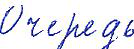

In [97]:
# 57347_16 хороший почерк
words = glob("./words/57347_16/**/*.jpg", recursive=True)
words.sort(key=lambda path: int(path.split('/')[-1].replace(".jpg", "")))
words.sort(key=lambda path: int(path.split('/')[-2]))
words.sort(key=lambda path: int(path.split('/')[-3][-1]))
word = words[0]
word_img = Image.open(word)
word_img

In [144]:
word_img.size

(134, 49)

In [ ]:
images, letters = recognition_another_try(
    "./words/57347_16",
    chain
    )

  0%|          | 0/274 [00:00<?, ?it/s]

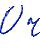

In [158]:
word_img.crop(
    [0, 0, 40, 49]
)

False


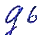

In [151]:
img_test = word_img.crop(
    [139-50, 0, word_img.width, 49]
)
img_test = preprocess(
        img_test,
        padding=5,
        min_contour=40,
        deacrease_contour_if_none=True,
      )

im = img_as_bool(binarize(img_test))
im = thin(binary_closing(skeletonize(im)))
# plt.imshow(im, cmap='gray')
im = im[5:-5, 5:-5]
print(im[:, -1].sum() < 2)
img_test

In [ ]:
# for word in tqdm(words):
#   parse_word_with_incremental_window(
#       path=word,
#       classifier=best_model,
#       chain=chain,
#       classes=class_names,
#       markov_threshold=0.05,
#       window_min_size=10,
#       save_img=True,
#       save_path="/content/drive/MyDrive/Disser/prediction_05-25_21-27-59"
#   )


In [ ]:
predict_image(best_model, class_names, Image.open("/content/drive/MyDrive/Disser/prediction_05-25_21-27-59/п/п-3.jpg"))

## Итог